# Vocabulary analysis
In this notebooks, I'll look for out-of-vocabulary words in each pairwise comparison of corpora. The more out-of-vocabulary words for a given pair, the less similar they are to one another. We expect that SciERC and PICKLE will have more overlapping vocabulary.

In [19]:
import jsonlines
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
import pandas as pd
import numpy as np

# Importing my own Dataset class
import sys
sys.path.append('../models/corpus_comparison/')
from dataset import Dataset

For this analysis, we'll use the SciERC, GENIA, and PICKLE corpora to get the sets of tokens that make up the three corpora. We'll then look for out-of-vocabulary words in each pairwise comparison of corpora. Based on the pre-trained model results, in which SciERC outperformed GENIA on the PICKLE corpus, we expect to see that there are more out-of-vocabulary words in the GENIA-PICKLE comparison than in the SciERC-PICKLE comparison.
### Getting our corpus vocabularies
First, we have to get the GENIA and SciERC datasets.

#### Downloading SciERC and GENIA data
We'll use the code provided in the [DyGIE++](https://github.com/dwadden/dygiepp) repo for this purpose, running the following commands from the root of the `dygiepp` repo:

```
bash ./scripts/data/get_scierc.sh
```

```
bash ./scripts/data/get_genia.sh
```

### Comparing vocabularies
Now that we have all three datasets, we can compare them. This is done with the script `out_of_vocab_comparison.py`, found in the `models/corpus_comparison` directory.

<br>

*A summary of the comparisons:* For each pair of datasets, a total of 6 metrics were calculated. For each of unigrams, bigrams, and trigrams, the datasets were compared in both directions, and the number of out-of-vocabulary words for that comparison were computed. In order to be able to compare the differences between PICKLE/GENIA and PICKLE/SciERC, the comparisons were normalized by the number of words of that n-gram length in the comparison corpus, making the final calculation equivalent to:

```len(set(ngrams in PICKLE) - set(ngrams in GENIA/SciERC)) / len(ngrams in GENIA/SciERC)```

#### Commands used to generate comparisons
The relative paths here are specific to my local filesystem/data directory structure, which doesn't come along with this repository. These commands were run form the `models/corpus_comparison/` directory.

To compare GENIA to PICKLE:
```
python out_of_vocab_comparison.py pickle ../../data/straying_off_topic_data/unified_annotations_processed/jsonl_files/FINAL_FOR_EVALUATION_ent_and_rel_all_gold_std_abstracts_08Nov2022.jsonl genia ../../../dygiepp/data/genia/processed-data/json-coref-ident-only/train.json  ../../data/straying_off_topic_data/corpus_comparison/ pickle_vs_genia_normalized -v
```

To compare SciERC to PICKLE:
```
python out_of_vocab_comparison.py pickle ../../data/straying_off_topic_data/unified_annotations_processed/jsonl_files/FINAL_FOR_EVALUATION_ent_and_rel_all_gold_std_abstracts_08Nov2022.jsonl scierc ../../../dygiepp/data/scierc/processed_data/json/train.json  ../../data/straying_off_topic_data/corpus_comparison/ pickle_vs_scierc_normalized -v
```

#### Looking at comparison outputs
Now, lets read in the data and see what the situation is.

In [20]:
genia_vs_pickle_path = '../data/straying_off_topic_data/corpus_comparison/pickle_vs_genia_normalized_oov_comparison.jsonl'
scierc_vs_pickle_path = '../data/straying_off_topic_data/corpus_comparison/pickle_vs_scierc_normalized_oov_comparison.jsonl'

In [21]:
genia_vs_pickle = []
with jsonlines.open(genia_vs_pickle_path) as reader:
    for obj in reader:
        genia_vs_pickle.append(obj)
        
scierc_vs_pickle = []
with jsonlines.open(scierc_vs_pickle_path) as reader:
    for obj in reader:
        scierc_vs_pickle.append(obj)

To better visualize the situation, let's make a bar plot!

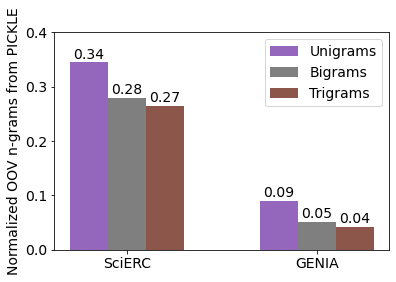

In [22]:
pickle_labels = ['SciERC', 'GENIA']
unigrams = [scierc_vs_pickle[0]['unigrams_oov_pickle_frac'], genia_vs_pickle[0]['unigrams_oov_pickle_frac']]
bigrams = [scierc_vs_pickle[0]['bigrams_oov_pickle_frac'], genia_vs_pickle[0]['bigrams_oov_pickle_frac']]
trigrams = [scierc_vs_pickle[0]['trigrams_oov_pickle_frac'], genia_vs_pickle[0]['trigrams_oov_pickle_frac']]

x = np.arange(len(pickle_labels))
x = 0.5*x
width = 0.1

fig, ax = plt.subplots()
ax.bar(x - width, unigrams, width, color='tab:purple', label='Unigrams')
ax.bar(x, bigrams, width, color='tab:grey', label='Bigrams')
ax.bar(x + width, trigrams, width, color='tab:brown', label='Trigrams')

for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.2f'),
               (bar.get_x() + bar.get_width() / 2,
               bar.get_height()), ha='center', va='center',
               size=14, xytext=(0,8),
               textcoords='offset points')

plt.ylabel('Normalized OOV n-grams from PICKLE')
plt.xticks(x, pickle_labels)
plt.ylim(0,0.4)
plt.legend(loc='upper right')

plt.savefig('../data/straying_off_topic_data/corpus_comparison/figures/oov_plot.png', bbox_inches='tight', dpi=300)

In all three categories, the amount of PICKLE's vocabulary that is out of the vocabulary of the other corpus is much greater for SciERC than for GENIA. This is the opposite of what we expected, since SciERC performs better for entity recognition on the PICKLE corpus than GENIA does. However, it's possible that the semantics of the words in SciERC are more similar to those in PICKLE than in GENIA, which could account for the phenomenon. That's what we'll look at next.